In [7]:
%matplotlib inline

import sys
sys.path.append('../lib')
sys.path.append('../utilities')

In [8]:
import pandas as pd
import numpy as np
import os
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import pickle

import datetime as dt

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

In [9]:
class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)
    ]

In [10]:
class DataRetrieve:   
    """Class of functions used to retrieve issue data"""
    def read_pickle_data(self, file_name, issue):
        """Reads data from a pickle file   
           Args:
                file_name: filename of pickle file
                issue: symbol of data to be retrieved
           Return:
                df: Dataframe of issue data
        """
        try:
            df = pd.read_pickle(file_name)
        except:
            print("================================")
            print("No information for ticker '%s'" % issue)
            print("================================")
            raise SystemExit
        print ("Successfully retrieved data series for " + issue)
        return df
        
    def read_issue_data(self, issue):
        """Reads equity from a pickle file   
           Args:
                issue: symbol of data to be retrieved
           Return:
                df: Dataframe of issue data
           To update: Set location of filename location outside of class
        """
        self.issue = issue
        issue_name = issue + '.pkl'
        file_name = os.path.join(r'C:\Users\kruegkj\kevinkr OneDrive\OneDrive\IssueData\Equity', issue_name)
        df = self.read_pickle_data(file_name, issue)
        return df
    
    def read_fred_data(self, issue):
        """Reads FRED data from a pickle file   
           Args:
                issue: symbol of data to be retrieved
           Return:
                df: Dataframe of issue data
           To update: Set location of filename location outside of class
        """
        self.issue = issue
        issue_name = issue + '.pkl'
        file_name = os.path.join(r'C:\Users\kruegkj\kevinkr OneDrive\OneDrive\IssueData\Auxiliary', issue_name)
        print(file_name)
        df = self.read_pickle_data(file_name, issue)
        return df
        
    def set_date_range(self, df, dfStartDt, dfEndDt, dateName='Date'):
        """Set US bus cal date range to be retrieved from datetimeindex   
           Args:
                df: dataframe of issue data
                dfStartDt: start date
                dfEndDt: end date
                dateName: name of Date column, default is 'Name'
           Return:
                df3: Dataframe of issue data
           To update: Set location of filename location outside of class
        """
        us_cal = CustomBusinessDay(calendar=USTradingCalendar())
        df.set_index(pd.to_datetime(df[dateName]), inplace=True)
        df3 = df.reindex(pd.date_range(start=dfStartDt, end=dfEndDt, freq=us_cal))
        return df3

    def drop_columns(self, df, col_vals):
        """Utility to drop columns   
           Args:
                df: dataframe of issue data
                col_vals: list of column names
           Return:
                df: Dataframe with columns dropped
           To update: Verify columns exist before dropping
        """
        df.drop(col_vals, axis =1, inplace=True)
        return df
    
    def save_obj(self, obj, name ):
        with open('../obj/'+ name + '.pkl', 'wb+') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
    def load_obj(self, name):
        with open('../obj/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)
    

In [11]:
class ComputeTarget:
    
    def setTarget(self, df, direction, beLongThreshold):
        """Set value of target to 1 if gainAhead>0, otherwise set to 0   
           Args:
                df: dataframe of issue data
                direction: long or short (currently unused, assume long)
                beLongThreshold: gain must be above this threshold to 
                    set direction
           Return:
                df: Dataframe with gainAhead and beLong columns added
           To update: Added direction and correct code to identify
               long and short thresholds and correct signal
        """
        df['gainAhead'] = ComputeTarget.gainAhead(df.Close)
        df['beLong'] = np.where(df.gainAhead>beLongThreshold,1,-1)
        return df

    def gainAhead(p):
        """Computes change in the next 1 bar. A change of 1% is 0.01.
           The final value is unknown.  Its value is 0.0. 
           Args:
                p: price series
           Return:
                g: numpy array of changes
        """
        nrows = p.shape[0]
        g = np.zeros(nrows)
        for i in range(0,nrows-1):
            g[i] = (p[i+1]-p[i])/p[i]
            # if % change is 0, change to small number
            if (abs(g[i]) < 0.0001):
                g[i] = 0.0001
        return g
        
    def priceChange(self, p):
        """Computes pricechange in the next 1 bar. 
           The final value is unknown.  Its value is 0.0. 
           Args:
                p: price series
           Return:
                pc: numpy array of changes
        """
        nrows = p.shape[0]
        pc = np.zeros(nrows)
        for i in range(1,nrows):
            pc[i] = (p[i]-p[i-1])/p[i-1]
        return pc

In [12]:
    from plot_utils import *
    plotIt = PlotUtility()
    
    dataLoadStartDate = "2014-04-01"
    dataLoadEndDate = "2018-06-01"
    issue = "TLT"
    aux_issue = "VIXCLS"
    threeMoTbill = "DTB3"
    
    dSet = DataRetrieve()
    dataSet = dSet.read_issue_data(issue)
    dataSet = dSet.set_date_range(
            dataSet, 
            dataLoadStartDate,
            dataLoadEndDate)
    
    vixDataSet = dSet.read_fred_data(aux_issue)
    vixDataSet = dSet.set_date_range(
            vixDataSet, 
            dataLoadStartDate,
            dataLoadEndDate,
            dateName="DATE")
    
    threeMoDataSet = dSet.read_fred_data(threeMoTbill)
    threeMoDataSet = dSet.set_date_range(
            threeMoDataSet, 
            dataLoadStartDate,
            dataLoadEndDate,
            dateName="DATE")
    
    beLongThreshold = 0.0
    ct = ComputeTarget()
    targetDataSet = ct.setTarget(
            dataSet, 
            "Long", 
            beLongThreshold)
    nrows = targetDataSet.shape[0]
    print ("nrows: ", nrows)
    print (targetDataSet.shape)
    print (targetDataSet.tail(10))

Successfully retrieved data series for TLT
C:\Users\kruegkj\kevinkr OneDrive\OneDrive\IssueData\Auxiliary\VIXCLS.pkl
Successfully retrieved data series for VIXCLS
C:\Users\kruegkj\kevinkr OneDrive\OneDrive\IssueData\Auxiliary\DTB3.pkl
Successfully retrieved data series for DTB3
nrows:  1051
(1051, 9)
           Symbol       Date   Close      High       Low    Open    Volume  \
2018-05-18    TLT 2018-05-18  117.21  117.2900  116.5100  116.51   9606468   
2018-05-21    TLT 2018-05-21  117.27  117.3800  116.9500  117.13   4448525   
2018-05-22    TLT 2018-05-22  117.09  117.3450  116.8510  117.29   4700736   
2018-05-23    TLT 2018-05-23  117.94  118.1100  117.6552  117.75   9633993   
2018-05-24    TLT 2018-05-24  118.88  119.0550  118.6408  118.69   8164813   
2018-05-25    TLT 2018-05-25  119.62  119.8400  119.4650  119.56   8482823   
2018-05-29    TLT 2018-05-29  122.24  122.5200  120.4261  120.79  21668143   
2018-05-30    TLT 2018-05-30  121.42  121.4799  120.7400  121.00  11270810

In [14]:
    print ("beLong counts: ")
    print (targetDataSet['beLong'].value_counts())
    print ("out of ", nrows)
    
    testFirstYear = "2014-04-01"
    testFinalYear = "2014-06-01"
    qtPlot = targetDataSet.ix[testFirstYear:testFinalYear]
    
    

beLong counts: 
 1    571
-1    480
Name: beLong, dtype: int64
out of  1051


In [15]:
import matplotlib.pyplot as plt

In [36]:
buys = qtPlot.ix[(qtPlot['beLong'] > 0)]
sells = qtPlot.ix[(qtPlot['beLong'] < 0)]

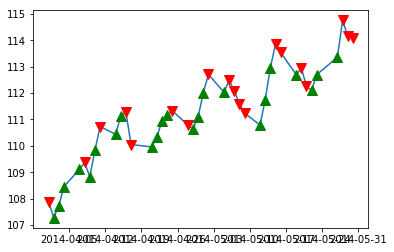

In [37]:
plt.plot(qtPlot.index, qtPlot['Close'])
plt.plot(buys.index, qtPlot.ix[buys.index]['Close'], '^', markersize=10, color='g')
plt.plot(sells.index, qtPlot.ix[sells.index]['Close'], 'v', markersize=10, color='r')
#plt.plot(qtPlot.index, qtPlot['beLong'])

In [24]:
print(qtPlot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2014-04-01 to 2014-05-30
Freq: C
Data columns (total 9 columns):
Symbol       42 non-null object
Date         42 non-null datetime64[ns]
Close        42 non-null float64
High         42 non-null float64
Low          42 non-null float64
Open         42 non-null float64
Volume       42 non-null int64
gainAhead    42 non-null float64
beLong       42 non-null int32
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(1)
memory usage: 3.1+ KB
None
